# Deep Learning pour Classification

Ce notebook regroupe quelques configurations d'algorithmes de Deep Learning pour la classification de données.

In [92]:
import numpy
import time

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from matplotlib import pyplot



Variable                        Possibilités             Nombre de colonne (+1)
Spécialité de médecins	        33 codes de spécialité	        1-33
Sexe de médecin 	            2	                            34-35
Langue de correspondance 	    2	                            36-37
Université de graduation 	    14 universités	                38-51
Plage horaire de facturation	3 (AM, PM, toute la journée)	52-54
Agence de représentation	    845 codes d’agences             55-899
Établissements                  241 établissements	            900-1140
ActeMedical                     2 (Oui et Non)	                1141-1142
Activités médico-admin          2 (Oui et Non)	                1143-1144
Activités d’enseignement	    2 (Oui et Non)	                1145-1146
Entente LE	                    2 (Oui et Non)	                1147-1148
Activité en santé communautaire	2 (Oui et Non)	                1149-1150
Activité en santé comm. CSST	2 (Oui et Non)	                1151-1152
Activité en santé 

In [116]:
labeledData = numpy.load('labeled.npy')
numberOfData = labeledData.shape[0] # 1441
dimensions = labeledData.shape[1] # 1183

# normaliser les données d'entrée entre 0 et 1 pour toutes les dimensions.
X_train = minmax_scale(labeledData[ : -((numberOfData//4)), :]) # 1081 premières données
X_test = minmax_scale(labeledData[(numberOfData//4)*3 + 1 : ,  :]) # 360 dernières données

def create_balanced_sampler(dataset):
    def make_weights_for_balanced_classes(images, n_classes):                        
        count = [0] * n_classes                                                      
        for item in images:                                                         
            count[int(item[1])] += 1                                                     
        weight_per_class = [0.] * n_classes                                      
        N = float(sum(count))                                                   
        for i in range(n_classes):                                                   
            weight_per_class[i] = N/float(count[i])                                 
        weight = [0] * len(images)                                              
        for idx, val in enumerate(images):                                          
            weight[idx] = weight_per_class[int(val[1])]                                  
        return weight

    n_classes = numpy.unique(dataset.targets)
    weights = make_weights_for_balanced_classes(dataset.data, len(n_classes))                                                         
    weights = torch.DoubleTensor(weights)                 
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 
    return sampler

def compute_accuracy(model, dataloader, device='cpu'):
    training_before = model.training
    model.eval()
    all_predictions = []
    all_targets = []
    
    for i_batch, batch in enumerate(dataloader):
        images, targets = batch
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            predictions = model(images)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    if all_predictions[0].shape[-1] > 1:
        predictions_numpy = numpy.concatenate(all_predictions, axis=0)
        predictions_numpy = predictions_numpy.argmax(axis=1)
        targets_numpy = numpy.concatenate(all_targets, axis=0)
    else:
        predictions_numpy = numpy.concatenate(all_predictions).squeeze(-1)
        targets_numpy = numpy.concatenate(all_targets)
        predictions_numpy[predictions_numpy >= 0.5] = 1.0
        predictions_numpy[predictions_numpy < 0.5] = 0.0

    if training_before:
        model.train()

    return (predictions_numpy == targets_numpy).mean()

In [117]:
class RAMQDataset(Dataset):
    """
    Cette classe sert à définir le dataset RAMQ pour PyTorch
    """

    def __init__(self, data):
        super().__init__()
        self.data = []
        for elem in data:
            if isinstance(elem, numpy.ndarray):
                elem = elem.tolist()
                elem_data = torch.Tensor(elem[:-1])
                elem_target = torch.FloatTensor([elem[-1]])
            # garde les paramètres en mémoire
            self.data += [(elem_data, elem_target[0])]
            
        self.targets = numpy.array(data[:, -1])

    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

In [118]:
class RAMQNet(nn.Module):
    """
    Cette classe définit un réseau permettant de classifier des données de la RAMQ
    """

    def __init__(self, n_inputs, n_layers, activation = nn.ELU()):
        super().__init__()
        
        reduction_ratio = (1/n_inputs)**(1/n_layers)
        
        layers = []
        layer_lenght = n_inputs
        
        # Calculate nb of layers and nb of neurons
        # Builds a list (ex:[1000, 500, 250, ... until 1])
        while layer_lenght > 1:
            layers.append(layer_lenght)
            layer_lenght = int(layer_lenght*reduction_ratio)
        layers.append(1)
        
        # Build encoder layers
        network_layers = []
        for i, n_neurons in enumerate(layers[:-1]):
            layer = nn.Linear(layers[i], layers[i+1])
            network_layers.append(layer)
            network_layers.append(activation)
            network_layers.append(nn.BatchNorm1d(layers[i+1]))
            # encoder_layers.append(nn.Dropout(0.5))
        network_layers[-1] = nn.Sigmoid()
            
        # Build pytorch sequential network
        self.network = nn.Sequential(
            *network_layers
        )
        
    def forward(self, x):

        # Exécute l'inférence du réseau. L'ordre 
        # d'exécution ici est important.
        x = self.network(x)
        
        return x

In [119]:
class RAMQNet2(nn.Module):
    """
    Cette classe définit un réseau permettant de classifier des données de la RAMQ
    """

    def __init__(self):
        super().__init__()
        
        # TODO Q1B
        # Initialiser ici les modules contenant des 
        # paramètres à optimiser. Ces modules seront
        # utilisés dans la méthode 'forward'
        
        self.F1 = nn.Linear(1182, 1)
#         self.F2 = nn.Linear(590, 295)
#         self.F3 = nn.Linear(295, 147)
#         self.F4 = nn.Linear(147, 74)
#         self.F5 = nn.Linear(74, 37)
#         self.F6 = nn.Linear(37, 18)
#         self.F7 = nn.Linear(18, 9)
#         self.F8 = nn.Linear(9, 1)
        self.output = nn.Sigmoid()
        
    def forward(self, x):

        # Exécute l'inférence du réseau. L'ordre 
        # d'exécution ici est important.
        x = self.F1(x)
#         x = F.elu(self.F2(x))
#         x = F.elu(self.F3(x))
#         x = F.elu(self.F4(x))
#         x = F.elu(self.F5(x))
#         x = F.elu(self.F6(x))
#         x = F.elu(self.F7(x))
#         x = F.elu(self.F8(x))
        
        # Couche sigmoide
        x = self.output(x)
        
        return x

Classification sans fonction d'activation de 1182 dimensions à 1: +- 84% de taux de réussite

Classification avec fonction d'activation elu à 9 couches: +- 82% de taux de réussite

Classification avec fonction d'activation relu à 9 couches: +- 50% de taux de réussite

In [130]:
def compute_results(X_train, X_test):
    # Définit si cuda est utilisé ou non
    # mettre cuda pour utiliser un GPU
    device = "cpu" #if torch.cuda.is_available() else "cpu"

    # Définit les paramètres d'entraînement 
    nb_epoch = 250
    learning_rate = 0.01
    momentum = 0.9
    batch_size = 32

    # Charge les données d'entraînement et de test
    train_set = RAMQDataset(X_train)
    test_set = RAMQDataset(X_test)

    # Crée le sampler avec les classes balancées
    balanced_train_sampler = create_balanced_sampler(train_set)
    balanced_test_sampler = create_balanced_sampler(test_set)

    # Crée le dataloader d'entraînement
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=balanced_train_sampler)
    test_loader = DataLoader(test_set, batch_size=batch_size, sampler=balanced_test_sampler)

    test_accu = []
    test_accu.append(0)

    # Instancier un réseau RAMQNet
    # dans une variable nommée "model"
    for i in range(1,10):
        print("Je vais utiliser " + str(i) + " layers")
        model = RAMQNet(1182, i)

        # Tranfert le réseau au bon endroit
        model.to(device)

        # Instancier une fonction d'erreur BinaryCrossEntropy
        # et la mettre dans une variable nommée criterion
        criterion = nn.BCELoss()

        # Instancier l'algorithme d'optimisation SGD
        # Ne pas oublier de lui donner les hyperparamètres
        # d'entraînement : learning rate et momentum!
        optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)

        # Mettre le réseau en mode entraînement
        model.train()

        for i_epoch in range(nb_epoch):

            start_time, train_losses = time.time(), []
            for i_batch, batch in enumerate(train_loader):
                values, targets = batch
                targets = targets.type(torch.FloatTensor).unsqueeze(-1)

                values = values.to(device)
                targets = targets.to(device)

                # Mettre les gradients à zéro
                optimizer.zero_grad()

                # Calculer:
                # 1. l'inférence dans une variable "predictions"
                # 2. l'erreur dans une variable "loss"
                predictions = model(values)
                loss = criterion(predictions, targets)

                # Rétropropager l'erreur et effectuer
                # une étape d'optimisation
                loss.backward()
                optimizer.step()

                # Ajoute le loss de la batch
                train_losses.append(loss.item())

            print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
            i_epoch+1, nb_epoch, numpy.mean(train_losses), time.time()-start_time))

        # affiche le score à l'écran
        test_acc = compute_accuracy(model, test_loader, device)
        print(' [-] test acc. {:.6f}%'.format(test_acc * 100))
        test_accu.append(test_acc)
    plot_results(test_accu)

In [129]:
def plot_results(test_accu):
    fig = pyplot.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(test_accu, label='Test accuracy')
    ax.set_xlim(1, 9)
    pyplot.grid()

    pyplot.show()

In [ ]:
compute_results(X_train, X_test) # all dimensions

Je vais utiliser 1 layers
 [-] epoch    1/250, train loss 0.684016 in 0.04s
 [-] epoch    2/250, train loss 0.661862 in 0.04s
 [-] epoch    3/250, train loss 0.640795 in 0.03s
 [-] epoch    4/250, train loss 0.614888 in 0.03s
 [-] epoch    5/250, train loss 0.608405 in 0.03s
 [-] epoch    6/250, train loss 0.593249 in 0.03s
 [-] epoch    7/250, train loss 0.576537 in 0.03s
 [-] epoch    8/250, train loss 0.567168 in 0.03s
 [-] epoch    9/250, train loss 0.564787 in 0.03s
 [-] epoch   10/250, train loss 0.559755 in 0.03s
 [-] epoch   11/250, train loss 0.555342 in 0.03s
 [-] epoch   12/250, train loss 0.547373 in 0.03s
 [-] epoch   13/250, train loss 0.549609 in 0.02s
 [-] epoch   14/250, train loss 0.540102 in 0.05s
 [-] epoch   15/250, train loss 0.522033 in 0.03s
 [-] epoch   16/250, train loss 0.518664 in 0.03s
 [-] epoch   17/250, train loss 0.524882 in 0.03s
 [-] epoch   18/250, train loss 0.503531 in 0.03s
 [-] epoch   19/250, train loss 0.521698 in 0.03s
 [-] epoch   20/250, tra

 [-] epoch  164/250, train loss 0.414458 in 0.03s
 [-] epoch  165/250, train loss 0.405862 in 0.03s
 [-] epoch  166/250, train loss 0.405939 in 0.04s
 [-] epoch  167/250, train loss 0.393107 in 0.03s
 [-] epoch  168/250, train loss 0.405447 in 0.03s
 [-] epoch  169/250, train loss 0.411389 in 0.03s
 [-] epoch  170/250, train loss 0.403053 in 0.03s
 [-] epoch  171/250, train loss 0.389008 in 0.03s
 [-] epoch  172/250, train loss 0.406091 in 0.03s
 [-] epoch  173/250, train loss 0.423183 in 0.03s
 [-] epoch  174/250, train loss 0.420626 in 0.03s
 [-] epoch  175/250, train loss 0.415777 in 0.03s
 [-] epoch  176/250, train loss 0.417823 in 0.03s
 [-] epoch  177/250, train loss 0.419064 in 0.03s
 [-] epoch  178/250, train loss 0.402400 in 0.03s
 [-] epoch  179/250, train loss 0.390408 in 0.03s
 [-] epoch  180/250, train loss 0.400570 in 0.03s
 [-] epoch  181/250, train loss 0.384642 in 0.03s
 [-] epoch  182/250, train loss 0.405511 in 0.03s
 [-] epoch  183/250, train loss 0.407632 in 0.03s


 [-] epoch   76/250, train loss 0.325216 in 0.07s
 [-] epoch   77/250, train loss 0.341046 in 0.08s
 [-] epoch   78/250, train loss 0.321242 in 0.07s
 [-] epoch   79/250, train loss 0.320729 in 0.08s
 [-] epoch   80/250, train loss 0.329151 in 0.06s
 [-] epoch   81/250, train loss 0.339699 in 0.07s
 [-] epoch   82/250, train loss 0.332607 in 0.07s
 [-] epoch   83/250, train loss 0.324163 in 0.06s
 [-] epoch   84/250, train loss 0.334242 in 0.08s
 [-] epoch   85/250, train loss 0.312684 in 0.06s
 [-] epoch   86/250, train loss 0.309928 in 0.06s
 [-] epoch   87/250, train loss 0.334483 in 0.08s
 [-] epoch   88/250, train loss 0.327341 in 0.07s
 [-] epoch   89/250, train loss 0.331884 in 0.06s
 [-] epoch   90/250, train loss 0.318575 in 0.08s
 [-] epoch   91/250, train loss 0.317480 in 0.07s
 [-] epoch   92/250, train loss 0.314461 in 0.07s
 [-] epoch   93/250, train loss 0.306076 in 0.07s
 [-] epoch   94/250, train loss 0.310591 in 0.07s
 [-] epoch   95/250, train loss 0.303035 in 0.07s


 [-] epoch  239/250, train loss 0.304131 in 0.23s
 [-] epoch  240/250, train loss 0.260637 in 0.20s
 [-] epoch  241/250, train loss 0.276081 in 0.17s
 [-] epoch  242/250, train loss 0.293006 in 0.15s
 [-] epoch  243/250, train loss 0.265084 in 0.15s
 [-] epoch  244/250, train loss 0.288482 in 0.12s
 [-] epoch  245/250, train loss 0.304602 in 0.12s
 [-] epoch  246/250, train loss 0.274558 in 0.10s
 [-] epoch  247/250, train loss 0.282636 in 0.12s
 [-] epoch  248/250, train loss 0.306250 in 0.12s
 [-] epoch  249/250, train loss 0.284318 in 0.12s
 [-] epoch  250/250, train loss 0.280544 in 0.12s
 [-] test acc. 79.166667%
Je vais utiliser 3 layers
 [-] epoch    1/250, train loss 0.573590 in 0.20s
 [-] epoch    2/250, train loss 0.453906 in 0.20s
 [-] epoch    3/250, train loss 0.441202 in 0.20s
 [-] epoch    4/250, train loss 0.377244 in 0.22s
 [-] epoch    5/250, train loss 0.419342 in 0.22s
 [-] epoch    6/250, train loss 0.409461 in 0.22s
 [-] epoch    7/250, train loss 0.376592 in 0.22

 [-] epoch  151/250, train loss 0.227968 in 0.15s
 [-] epoch  152/250, train loss 0.249769 in 0.15s
 [-] epoch  153/250, train loss 0.228946 in 0.15s
 [-] epoch  154/250, train loss 0.218816 in 0.15s
 [-] epoch  155/250, train loss 0.253945 in 0.14s
 [-] epoch  156/250, train loss 0.231303 in 0.14s
 [-] epoch  157/250, train loss 0.239086 in 0.15s
 [-] epoch  158/250, train loss 0.224775 in 0.13s
 [-] epoch  159/250, train loss 0.221559 in 0.15s
 [-] epoch  160/250, train loss 0.235301 in 0.13s
 [-] epoch  161/250, train loss 0.230864 in 0.15s
 [-] epoch  162/250, train loss 0.228827 in 0.13s
 [-] epoch  163/250, train loss 0.254608 in 0.13s
 [-] epoch  164/250, train loss 0.224647 in 0.15s
 [-] epoch  165/250, train loss 0.237250 in 0.15s
 [-] epoch  166/250, train loss 0.229280 in 0.13s
 [-] epoch  167/250, train loss 0.219061 in 0.15s
 [-] epoch  168/250, train loss 0.232664 in 0.13s
 [-] epoch  169/250, train loss 0.227717 in 0.15s
 [-] epoch  170/250, train loss 0.233768 in 0.13s


 [-] epoch   63/250, train loss 0.250287 in 0.20s
 [-] epoch   64/250, train loss 0.269422 in 0.22s
 [-] epoch   65/250, train loss 0.278733 in 0.20s
 [-] epoch   66/250, train loss 0.254127 in 0.22s
 [-] epoch   67/250, train loss 0.252218 in 0.21s
 [-] epoch   68/250, train loss 0.246277 in 0.19s
 [-] epoch   69/250, train loss 0.270233 in 0.20s
 [-] epoch   70/250, train loss 0.253645 in 0.18s
 [-] epoch   71/250, train loss 0.256966 in 0.20s
 [-] epoch   72/250, train loss 0.240483 in 0.21s
 [-] epoch   73/250, train loss 0.267124 in 0.22s
 [-] epoch   74/250, train loss 0.245809 in 0.21s
 [-] epoch   75/250, train loss 0.257684 in 0.20s
 [-] epoch   76/250, train loss 0.239357 in 0.20s
 [-] epoch   77/250, train loss 0.260114 in 0.22s
 [-] epoch   78/250, train loss 0.252699 in 0.23s
 [-] epoch   79/250, train loss 0.250252 in 0.22s
 [-] epoch   80/250, train loss 0.245354 in 0.22s
 [-] epoch   81/250, train loss 0.251261 in 0.21s
 [-] epoch   82/250, train loss 0.260362 in 0.22s


 [-] epoch  226/250, train loss 0.204192 in 0.20s
 [-] epoch  227/250, train loss 0.220727 in 0.23s
 [-] epoch  228/250, train loss 0.218987 in 0.21s
 [-] epoch  229/250, train loss 0.218472 in 0.21s
 [-] epoch  230/250, train loss 0.222913 in 0.19s
 [-] epoch  231/250, train loss 0.201420 in 0.21s
 [-] epoch  232/250, train loss 0.215861 in 0.21s
 [-] epoch  233/250, train loss 0.208750 in 0.21s
 [-] epoch  234/250, train loss 0.214478 in 0.22s
 [-] epoch  235/250, train loss 0.206910 in 0.21s
 [-] epoch  236/250, train loss 0.191383 in 0.21s
 [-] epoch  237/250, train loss 0.197014 in 0.20s
 [-] epoch  238/250, train loss 0.188810 in 0.20s
 [-] epoch  239/250, train loss 0.195770 in 0.21s
 [-] epoch  240/250, train loss 0.203091 in 0.20s
 [-] epoch  241/250, train loss 0.217243 in 0.22s
 [-] epoch  242/250, train loss 0.213428 in 0.21s
 [-] epoch  243/250, train loss 0.203277 in 0.21s
 [-] epoch  244/250, train loss 0.204291 in 0.20s
 [-] epoch  245/250, train loss 0.192533 in 0.21s


 [-] epoch  138/250, train loss 0.231395 in 0.34s
 [-] epoch  139/250, train loss 0.230087 in 0.31s
 [-] epoch  140/250, train loss 0.224450 in 0.36s
 [-] epoch  141/250, train loss 0.220628 in 0.32s
 [-] epoch  142/250, train loss 0.231560 in 0.32s
 [-] epoch  143/250, train loss 0.226314 in 0.31s
 [-] epoch  144/250, train loss 0.225306 in 0.33s
 [-] epoch  145/250, train loss 0.222398 in 0.33s
 [-] epoch  146/250, train loss 0.238202 in 0.30s
 [-] epoch  147/250, train loss 0.227511 in 0.32s
 [-] epoch  148/250, train loss 0.237000 in 0.32s
 [-] epoch  149/250, train loss 0.226649 in 0.30s
 [-] epoch  150/250, train loss 0.221411 in 0.31s
 [-] epoch  151/250, train loss 0.217749 in 0.32s
 [-] epoch  152/250, train loss 0.229349 in 0.32s
 [-] epoch  153/250, train loss 0.242800 in 0.30s
 [-] epoch  154/250, train loss 0.225047 in 0.31s
 [-] epoch  155/250, train loss 0.201508 in 0.32s
 [-] epoch  156/250, train loss 0.220211 in 0.30s
 [-] epoch  157/250, train loss 0.220883 in 0.33s


 [-] epoch   50/250, train loss 0.273279 in 0.40s
 [-] epoch   51/250, train loss 0.276461 in 0.43s
 [-] epoch   52/250, train loss 0.289009 in 0.41s
 [-] epoch   53/250, train loss 0.266421 in 0.43s
 [-] epoch   54/250, train loss 0.250611 in 0.40s
 [-] epoch   55/250, train loss 0.286093 in 0.40s
 [-] epoch   56/250, train loss 0.281653 in 0.42s
 [-] epoch   57/250, train loss 0.264741 in 0.40s
 [-] epoch   58/250, train loss 0.252563 in 0.38s
 [-] epoch   59/250, train loss 0.280141 in 0.42s
 [-] epoch   60/250, train loss 0.269041 in 0.40s
 [-] epoch   61/250, train loss 0.239710 in 0.44s
 [-] epoch   62/250, train loss 0.252984 in 0.42s
 [-] epoch   63/250, train loss 0.258506 in 0.42s
 [-] epoch   64/250, train loss 0.276205 in 0.43s
 [-] epoch   65/250, train loss 0.252156 in 0.43s
 [-] epoch   66/250, train loss 0.249483 in 0.42s
 [-] epoch   67/250, train loss 0.248084 in 0.41s
 [-] epoch   68/250, train loss 0.261335 in 0.39s
 [-] epoch   69/250, train loss 0.255085 in 0.41s


 [-] epoch  213/250, train loss 0.212187 in 0.41s
 [-] epoch  214/250, train loss 0.204288 in 0.40s
 [-] epoch  215/250, train loss 0.213572 in 0.42s
 [-] epoch  216/250, train loss 0.211378 in 0.42s
 [-] epoch  217/250, train loss 0.226516 in 0.43s
 [-] epoch  218/250, train loss 0.215574 in 0.44s
 [-] epoch  219/250, train loss 0.191364 in 0.44s
 [-] epoch  220/250, train loss 0.203596 in 0.44s
 [-] epoch  221/250, train loss 0.211390 in 0.44s
 [-] epoch  222/250, train loss 0.196838 in 0.46s
 [-] epoch  223/250, train loss 0.219917 in 0.46s
 [-] epoch  224/250, train loss 0.210412 in 0.44s
 [-] epoch  225/250, train loss 0.201715 in 0.41s
 [-] epoch  226/250, train loss 0.205574 in 0.42s
 [-] epoch  227/250, train loss 0.197051 in 0.40s
 [-] epoch  228/250, train loss 0.185865 in 0.40s
 [-] epoch  229/250, train loss 0.192022 in 0.40s
 [-] epoch  230/250, train loss 0.200653 in 0.40s
 [-] epoch  231/250, train loss 0.195299 in 0.41s
 [-] epoch  232/250, train loss 0.193022 in 0.38s


 [-] epoch  125/250, train loss 0.214755 in 0.51s
 [-] epoch  126/250, train loss 0.209020 in 0.53s
 [-] epoch  127/250, train loss 0.223222 in 0.47s
 [-] epoch  128/250, train loss 0.224888 in 0.51s
 [-] epoch  129/250, train loss 0.228024 in 0.50s
 [-] epoch  130/250, train loss 0.224813 in 0.49s
 [-] epoch  131/250, train loss 0.211195 in 0.51s
 [-] epoch  132/250, train loss 0.234628 in 0.50s
 [-] epoch  133/250, train loss 0.214915 in 0.50s
 [-] epoch  134/250, train loss 0.222965 in 0.51s
 [-] epoch  135/250, train loss 0.216649 in 0.50s
 [-] epoch  136/250, train loss 0.217235 in 0.52s
 [-] epoch  137/250, train loss 0.246501 in 0.52s
 [-] epoch  138/250, train loss 0.252069 in 0.53s
 [-] epoch  139/250, train loss 0.220427 in 0.49s
 [-] epoch  140/250, train loss 0.221364 in 0.54s
 [-] epoch  141/250, train loss 0.235168 in 0.49s
 [-] epoch  142/250, train loss 0.245440 in 0.51s
 [-] epoch  143/250, train loss 0.221284 in 0.49s
 [-] epoch  144/250, train loss 0.226793 in 0.50s


 [-] epoch   37/250, train loss 0.297765 in 0.63s
 [-] epoch   38/250, train loss 0.281749 in 0.62s
 [-] epoch   39/250, train loss 0.311174 in 0.60s
 [-] epoch   40/250, train loss 0.330169 in 0.60s
 [-] epoch   41/250, train loss 0.285001 in 0.60s
 [-] epoch   42/250, train loss 0.287069 in 0.58s
 [-] epoch   43/250, train loss 0.288924 in 0.61s
 [-] epoch   44/250, train loss 0.284677 in 0.62s
 [-] epoch   45/250, train loss 0.287342 in 0.60s
 [-] epoch   46/250, train loss 0.265765 in 0.62s
 [-] epoch   47/250, train loss 0.272805 in 0.60s
 [-] epoch   48/250, train loss 0.266803 in 0.62s
 [-] epoch   49/250, train loss 0.258879 in 0.59s
 [-] epoch   50/250, train loss 0.264823 in 0.61s
 [-] epoch   51/250, train loss 0.266151 in 0.60s
 [-] epoch   52/250, train loss 0.301971 in 0.63s
 [-] epoch   53/250, train loss 0.274453 in 0.61s
 [-] epoch   54/250, train loss 0.283118 in 0.62s
 [-] epoch   55/250, train loss 0.275868 in 0.62s
 [-] epoch   56/250, train loss 0.284721 in 0.65s


 [-] epoch  200/250, train loss 0.199431 in 0.57s
 [-] epoch  201/250, train loss 0.207515 in 0.58s
 [-] epoch  202/250, train loss 0.210722 in 0.55s
 [-] epoch  203/250, train loss 0.188055 in 0.55s
 [-] epoch  204/250, train loss 0.218553 in 0.59s
 [-] epoch  205/250, train loss 0.218676 in 0.54s
 [-] epoch  206/250, train loss 0.219890 in 0.55s
 [-] epoch  207/250, train loss 0.210153 in 0.56s
 [-] epoch  208/250, train loss 0.206388 in 0.56s
 [-] epoch  209/250, train loss 0.203166 in 0.57s
 [-] epoch  210/250, train loss 0.221590 in 0.58s
 [-] epoch  211/250, train loss 0.210335 in 0.58s
 [-] epoch  212/250, train loss 0.180481 in 0.56s
 [-] epoch  213/250, train loss 0.193248 in 0.59s
 [-] epoch  214/250, train loss 0.216077 in 0.57s
 [-] epoch  215/250, train loss 0.225552 in 0.57s
 [-] epoch  216/250, train loss 0.212106 in 0.58s
 [-] epoch  217/250, train loss 0.209134 in 0.53s
 [-] epoch  218/250, train loss 0.227465 in 0.54s
 [-] epoch  219/250, train loss 0.207920 in 0.55s


 [-] epoch  112/250, train loss 0.237016 in 0.61s
 [-] epoch  113/250, train loss 0.227787 in 0.63s
 [-] epoch  114/250, train loss 0.242931 in 0.60s
 [-] epoch  115/250, train loss 0.256620 in 0.59s
 [-] epoch  116/250, train loss 0.232460 in 0.63s
 [-] epoch  117/250, train loss 0.242589 in 0.65s
 [-] epoch  118/250, train loss 0.239124 in 0.63s
 [-] epoch  119/250, train loss 0.224285 in 0.65s
 [-] epoch  120/250, train loss 0.217321 in 0.61s
 [-] epoch  121/250, train loss 0.227856 in 0.67s
 [-] epoch  122/250, train loss 0.219744 in 0.61s
 [-] epoch  123/250, train loss 0.225974 in 0.63s
 [-] epoch  124/250, train loss 0.230650 in 0.66s
 [-] epoch  125/250, train loss 0.225265 in 0.63s
 [-] epoch  126/250, train loss 0.220828 in 0.64s
 [-] epoch  127/250, train loss 0.206120 in 0.64s
 [-] epoch  128/250, train loss 0.222184 in 0.67s
 [-] epoch  129/250, train loss 0.216482 in 0.66s
 [-] epoch  130/250, train loss 0.209406 in 0.65s
 [-] epoch  131/250, train loss 0.226157 in 0.63s


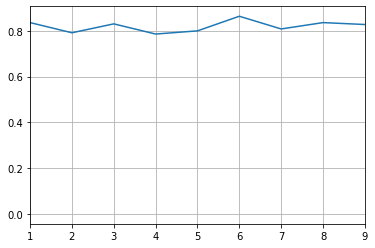

In [131]:
reducedData = numpy.load('labeled_reduit_100dim.npy')
numberOfData = labeledData.shape[0] # 1441
dimensions = labeledData.shape[1] # 1183

# normaliser les données d'entrée entre 0 et 1 pour toutes les dimensions.
X_train_reduced = minmax_scale(reducedData[ : -((numberOfData//4)), :]) # 1081 premières données
X_test_reduced = minmax_scale(reducedData[(numberOfData//4)*3 + 1 : ,  :]) # 360 dernières données

compute_results(X_train_reduced, X_test_reduced)

In [86]:
# Linear SVM performance with all dimensions
clf = LinearSVC()
clf.fit(X_train[:, : -1], X_train[:, -1])
score = clf.score(X_test[:, : -1], X_test[:, -1])
print("Score on all dimensions:", score)

Score on all dimensions: 0.8361111111111111


Tenir compte du fait que l'on n'a pas beaucoup de données considérant le nombre de dimensions

2 et 6 layers ressortent souvent (impression?) possibilité d'avoir une genre d'interférence